In [1]:
import sys
import os
import sympy as sp
import numpy as np

# Add the correct path to the P2 folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from gauss_fehlerfortpflanzung import evaluate_gaussian_error
from geraden_fit import geraden_fit
from scientific_error_rounder import runden_und_speichern
from mean_calc_w_err import err_weighted_mean

In [68]:
import sympy as sp
from gauss_fehlerfortpflanzung import gaussian_error_propagation

def check_premisse(input_file):
    # Datei einlesen
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Überspringe die erste Zeile (Spaltennamen)
    data = [line.split() for line in lines[1:]]

    # Konvertiere Werte zu float oder None
    parsed_data = [[float(val) if val != 'None' else None for val in row] for row in data]

    # Extrahiere Werte und Fehler
    n_values = 5  # Anzahl der Werte pro Kategorie
    categories = ['t_up', 't_mid', 't_down']

    # Symbole definieren (außerhalb der Schleife)
    t_up_mean, t_mid_mean, t_down_mean = sp.symbols('t_up_mean t_mid_mean t_down_mean')
    formula = 2 * 0.0005 / t_mid_mean - (0.0005 / t_down_mean - 0.0005 / t_up_mean)  # Beispiel

    for row_idx, row in enumerate(parsed_data):
        print(f"\nZeile {row_idx + 1}:")
        
        # Werte und Fehler für jede Kategorie extrahieren
        t_up_values = [row[j] for j in range(0, 10, 2)]
        t_up_errors = [row[j] for j in range(1, 10, 2)]
        t_mid_values = [row[j] for j in range(10, 20, 2)]
        t_mid_errors = [row[j] for j in range(11, 20, 2)]
        t_down_values = [row[j] for j in range(20, 30, 2)]
        t_down_errors = [row[j] for j in range(21, 30, 2)]

        # Iteriere über die Wertepaare
        for k in range(n_values):
            values = [t_up_values[k], t_mid_values[k], t_down_values[k]]
            errors = [t_up_errors[k], t_mid_errors[k], t_down_errors[k]]

            # Überspringe, wenn ein Wert fehlt
            if None in values or None in errors:
                continue

            # Debugging: Werte und Fehler prüfen
            #print(f"Werte: {values}, Fehler: {errors}")

            # Variablen und Werte für die Fehlerfortpflanzung
            variables = [
                [t_up_mean, values[0], errors[0]],
                [t_mid_mean, values[1], errors[1]],
                [t_down_mean, values[2], errors[2]],
            ]

            # Fehlerfortpflanzung berechnen
            try:
                    gaussian_error_propagation(
                    formula=formula,
                    variables=variables,
                    output=True # Annahme: Ausgabe wird benötigt
                )
            except Exception as e:
                print(f"Fehler bei der Berechnung: {e}")


# Beispiel: Datei verarbeiten
check_premisse('c_mess.txt')



Zeile 1:
Formel: 0.0005/t_up_mean + 0.001/t_mid_mean - 0.0005/t_down_mean
Werte: [[t_up_mean, 5.34, 0.25], [t_mid_mean, 1.74, 0.25], [t_down_mean, 1.61, 0.25]] 

Formelwert: 0.000357786596268479

Fehlerformel: sqrt((-0.0005*del_t_up_mean/t_up_mean**2)**2 + (-0.001*del_t_mid_mean/t_mid_mean**2)**2 + (0.0005*del_t_down_mean/t_down_mean**2)**2)
Fehler: 0.0000957242143636461 
Ergebnis: 0.0004±0.0001

Zeile 2:
Formel: 0.0005/t_up_mean + 0.001/t_mid_mean - 0.0005/t_down_mean
Werte: [[t_up_mean, 3.28, 0.25], [t_mid_mean, 2.95, 0.25], [t_down_mean, 0.84, 0.25]] 

Formelwert: -0.000103816020000394

Fehlerformel: sqrt((-0.0005*del_t_up_mean/t_up_mean**2)**2 + (-0.001*del_t_mid_mean/t_mid_mean**2)**2 + (0.0005*del_t_down_mean/t_down_mean**2)**2)
Fehler: 0.000179844010676688 
Ergebnis: -0.0001±0.0002
Formel: 0.0005/t_up_mean + 0.001/t_mid_mean - 0.0005/t_down_mean
Werte: [[t_up_mean, 3.1, 0.25], [t_mid_mean, 2.95, 0.25], [t_down_mean, 0.91, 0.25]] 

Formelwert: -0.0000491771760224467

Fehlerforme

In [35]:
def process_results_to_table(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    results = []
    current_line_results = []

    for line in lines:
        line = line.strip()

        # Erkenne neue Zeile basierend auf dem Header
        if line.startswith("Zeile"):
            if current_line_results:
                # Fülle auf 5 Ergebnisse mit None, falls weniger vorhanden
                while len(current_line_results) < 5:
                    current_line_results.append((None, None))
                results.append(current_line_results)
                current_line_results = []
        elif line.startswith("Formelwert:"):
            # Extrahiere den Formelwert
            formula_value = float(line.split(":")[1].strip())
        elif line.startswith("Fehler:"):
            # Extrahiere den Fehler
            error_value = float(line.split(":")[1].strip())
            current_line_results.append((formula_value, error_value))

    # Letzte Zeile hinzufügen, falls sie nicht leer ist
    if current_line_results:
        while len(current_line_results) < 5:
            current_line_results.append((None, None))
        results.append(current_line_results)

    # Schreibe die Ergebnisse in eine neue Datei
    with open(output_file, 'w') as file:
        # Spaltennamen erstellen
        header = []
        for i in range(1, 6):
            header.append(f"Formelwert_{i}")
            header.append(f"Fehler_{i}")
        file.write("\t".join(header) + "\n")

        # Ergebnisse Zeile für Zeile schreiben
        for result in results:
            row = []
            for value, error in result:
                row.append(f"{value:.6f}" if value is not None else "None")
                row.append(f"{error:.6f}" if error is not None else "None")
            file.write("\t".join(row) + "\n")

    print(f"Ergebnisse erfolgreich in '{output_file}' gespeichert.")

# Beispielaufruf
input_file = "c_Korrektur_manuell.txt"  # Die Datei mit dem zwischengespeicherten Output
output_file = "c_Korrektur_resultat.txt"  # Datei für die vereinfachten Ergebnisse
process_results_to_table(input_file, output_file)



Ergebnisse erfolgreich in 'c_Korrektur_resultat.txt' gespeichert.


Aus der Korrektur entnehmen wir, dass die folgenden Werte verworfen werden muessen:
Tropfen Reihe
1 1
3 1
8 1
13 1

(14 [2, 3, 5])
(15 1)

Für die Tropfen 14 und 15 sind dabei die Abweichungen (mit abgezogenem Fehler) so gering, dass wir eher auf einen sehr geringen nicht beachteten systematischen Fehler schliessen und die Werte als valide betrachten, obwohl die 0 nicht innerhalb der statistischen Fehlerbereiche liegt. 


In [38]:
# Mittelwerte bilden:
import numpy as np

def mean_calc(z_input, err_input, goal='data weighting'):
    """
    Berechnet den gewichteten Mittelwert eines Wertearrays unter Berücksichtigung individueller Fehlerwerte.
    """
    valid_indices = [i for i in range(len(z_input)) if z_input[i] is not None and err_input[i] is not None]

    if not valid_indices:  # Keine gültigen Werte
        return None

    if len(valid_indices) == 1:  # Nur ein gültiger Wert
        value = z_input[valid_indices[0]]
        error = err_input[valid_indices[0]]
        return value if goal == 'data weighting' else error

    z_input = np.array([z_input[i] for i in valid_indices])
    err_input = np.array([err_input[i] for i in valid_indices])

    mean_1 = np.sum(z_input / err_input ** 2)
    mean_2 = np.sum(1 / err_input ** 2)

    if mean_2 == 0:  # Schutz gegen Division durch Null
        return None

    if goal == 'data weighting':
        return mean_1 / mean_2
    elif goal == 'error':
        return np.sqrt(1 / mean_2)


def process_file(input_file, output_file):
    # Datei einlesen
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Überspringe die erste Zeile (Spaltennamen)
    data = [line.split() for line in lines[1:]]

    # Debugging: Eingabedaten prüfen
    print("Eingabedaten:")
    for line in data[:5]:  # Nur die ersten 5 Zeilen anzeigen
        print(line)

    # Konvertiere Werte zu float oder None
    parsed_data = [[float(val) if val != 'None' else None for val in row] for row in data]

    # Debugging: Konvertierte Daten prüfen
    print("\nKonvertierte Daten (erste Zeilen):")
    for row in parsed_data[:5]:
        print(row)

    # Extrahiere Werte und Fehler
    n_values = 5  # Anzahl der Werte pro Kategorie
    categories = ['t_up', 't_mid', 't_down']
    results = []

    for row_idx, row in enumerate(parsed_data):
        row_results = []
        for i, category in enumerate(categories):
            # Werte und Fehler korrekt extrahieren
            values = [row[j] for j in range(i * 10, i * 10 + 10, 2)]
            errors = [row[j] for j in range(i * 10 + 1, i * 10 + 10, 2)]

            # Debugging: Überprüfen, welche Werte extrahiert wurden
            print(f"\nZeile {row_idx + 1}, Kategorie {categories[i]}:")
            print(f"Werte: {values}")
            print(f"Fehler: {errors}")

            # Berechnung des gewichteten Mittels und des Fehlers
            mean_val = mean_calc(values, errors, goal='data weighting')
            mean_err = mean_calc(values, errors, goal='error')

            # Debugging: Ergebnisse der Berechnungen prüfen
            print(f"Berechnetes Mittel: {mean_val}")
            print(f"Berechneter Fehler: {mean_err}")

            row_results.extend([mean_val, mean_err])
        results.append(row_results)

    # Speichern der Ergebnisse in eine txt-Datei
    with open(output_file, 'w') as file:
        # Spaltennamen schreiben
        col_names = [f"{cat}_mean\t{cat}_err" for cat in categories]
        file.write("\t".join(col_names) + "\n")

        # Ergebnisse Zeile für Zeile schreiben
        for result in results:
            line = "\t".join(f"{val:.4f}" if val is not None else "None" for val in result)
            file.write(line + "\n")

    print("\nErgebnisse erfolgreich geschrieben in:", output_file)


# Beispiel: Datei verarbeiten
input_file = 'c.txt'  # Name der Eingabedatei
output_file = 'c_mean.txt'  # Name der Ausgabedatei
process_file(input_file, output_file)


Eingabedaten:
['3.28', '0.25', '3.1', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', '2.95', '0.25', '2.95', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', '0.84', '0.25', '0.91', '0.25', 'None', 'None', 'None', 'None', 'None', 'None']
['2.48', '0.25', '2.87', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '1.04', '0.25', '0.62', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '0.44', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
['0.38', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '1.32', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '0.19', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
['4.56', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '3.46', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', '1.44', '0.25', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
['0.44', '0.25', '0.64'

In [ ]:
### berechne v ###
# 5Kacheln = 0.5mm = 0.0005m
d = 0.0005
var_names=[t_up_mean, t_mid_mean,	t_down_mean]=sp.symbols('t_up_mean	t_mid_mean	t_down_mean')
formula_list=[
    d/t_up_mean, #v_up
    d/t_mid_mean, #v_0
    d/t_down_mean, #v_down
] 
evaluate_gaussian_error('c_mean.txt',formulas=formula_list, variables=var_names, result_length=10,result_names=['v_up', 'v_0', 'v_down'], output_file_suffix= 'v')



sqrt((-0.0005*del_t_up_mean/t_up_mean**2)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (-0.0005*del_t_mid_mean/t_mid_mean**2)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (-0.0005*del_t_down_mean/t_down_mean**2)**2)
Zeile 1: [0.0001567398, 8.687e-06, 0.0001694915, 1.0158e-05, 0.0005714286, 0.0001154612]
Zeile 2: [0.0002016129, 2.03239e-05, 0.0004807692, 0.0001155695, 0.0011363636, 0.0006456612]
Zeile 3: [0.0013157895, 0.000865651, 0.0003787879, 7.17401e-05, 0.0026315789, 0.0034626039]
Zeile 4: [0.0001096491, 6.0115e-06, 0.0001445087, 1.04414e-05, 0.0003472222, 6.02816e-05]
Zeile 5: [0.0009433962, 0.000256853, 0.000245098, 1.73371e-05, 0.001369863, 0.0006635391]
Zeile 6: [0.0007407407, 0.0001940192, 0.0003424658, 4.14712e-05, 0.0012195122, 0.0005258775]
Zeile 7: [0.0007575758, 0.0002869605, 0.0001805054, 1.62911e-05, 0.0012195122, 0.000743605]
Zeile 8: [0.0006756757, 0.0002282688, 0.0001923077, 1.84911e-05, 0.0014285714, 0.0010204082]
Zeile 9: [0.0005434783, 0.0001476843, 0.0001557632, 1.21311e-05, 0.000

In [41]:
runden_und_speichern('c_mean.txt')
runden_und_speichern('c_mean_v.txt')

Die gerundeten Daten wurden in der Datei "c_mean_rounded.txt" gespeichert.
Die gerundeten Daten wurden in der Datei "c_mean_v_rounded.txt" gespeichert.


In [71]:
my, roh_oel, roh_Luft = 0.00001819, 886, 1.225
var_names=[v_up_mean, v_mid_mean, v_down_mean, g, E]=sp.symbols('v_up_mean	v_mid_mean	v_down_mean g E')
            
formula_list=[
    sp.sqrt((9*my*(v_down_mean - v_up_mean))/(4*g*(roh_oel - roh_Luft))),
    v_up_mean,
    v_mid_mean,
    v_down_mean,
    g,
    E
] # spezifische Ladung e/m
evaluate_gaussian_error('c_v_g_E.txt',formulas=formula_list, variables=var_names, result_length=10,result_names=['r', 'v_up_mean', 'v_mid_mean', 'v_down_mean', 'g', 'E'], output_file_suffix= 'my_r')

sqrt((-1.37593778080193e-6*del_v_up_mean*sqrt((0.00016371*v_down_mean - 0.00016371*v_up_mean)/g)/(0.00016371*v_down_mean - 0.00016371*v_up_mean))**2 + (0)**2 + (1.37593778080193e-6*del_v_down_mean*sqrt((0.00016371*v_down_mean - 0.00016371*v_up_mean)/g)/(0.00016371*v_down_mean - 0.00016371*v_up_mean))**2 + (-0.00840472653351613*del_g*sqrt((0.00016371*v_down_mean - 0.00016371*v_up_mean)/g)/g)**2 + (0)**2)
sqrt((del_v_up_mean)**2 + (0)**2 + (0)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (del_v_mid_mean)**2 + (0)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (del_v_down_mean)**2 + (0)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (0)**2 + (del_g)**2 + (0)**2)
sqrt((0)**2 + (0)**2 + (0)**2 + (0)**2 + (del_E)**2)
Zeile 1: [1.3983e-06, 1.952e-07, 0.0001567398, 8.687e-06, 0.0001694915, 1.0158e-05, 0.0005714286, 0.0001154612, 9.8107, 0.02, 510.0, 1.0]
Zeile 2: [2.0994e-06, 7.254e-07, 0.0002016129, 2.03239e-05, 0.0004807692, 0.0001155695, 0.0011363636, 0.0006456612, 9.8107, 0.02, 510.0, 1.0]
Zeile 3: [2.4908e-06,

In [84]:
my, roh_oel, roh_Luft = 0.00001819, 886, 1.225
var_names=[r, v_up_mean, v_mid_mean, v_down_mean, g, E,]=sp.symbols('r v_up_mean	v_mid_mean	v_down_mean g E')
            
formula_list=[
    3*sp.pi*my*r*(v_down_mean - v_up_mean)/E,
    3*sp.pi*my*r*(v_down_mean - v_up_mean)/E
] # spezifische Ladung e/m
evaluate_gaussian_error('c_v_g_E_my_r.txt',formulas=formula_list, variables=var_names, result_length=20,result_names=['Ne', 'Ne'], output_file_suffix= '_Ne_gg_Ne')



sqrt((5.457e-5*pi*del_r*(v_down_mean - v_up_mean)/E)**2 + (-5.457e-5*pi*del_v_up_mean*r/E)**2 + (0)**2 + (5.457e-5*pi*del_v_down_mean*r/E)**2 + (0)**2 + (-5.457e-5*pi*del_E*r*(v_down_mean - v_up_mean)/E**2)**2)
sqrt((5.457e-5*pi*del_r*(v_down_mean - v_up_mean)/E)**2 + (-5.457e-5*pi*del_v_up_mean*r/E)**2 + (0)**2 + (5.457e-5*pi*del_v_down_mean*r/E)**2 + (0)**2 + (-5.457e-5*pi*del_E*r*(v_down_mean - v_up_mean)/E**2)**2)
Zeile 1: [1.9492e-16, 6.085e-17, 1.9492e-16, 6.085e-17]
Zeile 2: [6.5967e-16, 5.0969e-16, 6.5967e-16, 5.0969e-16]
Zeile 3: [1.10169e-15, 3.34113e-15, 1.10169e-15, 3.34113e-15]
Zeile 4: [8.452e-17, 2.41e-17, 8.452e-17, 2.41e-17]
Zeile 5: [2.0328e-16, 3.7919e-16, 2.0328e-16, 3.7919e-16]
Zeile 6: [2.4181e-16, 3.1652e-16, 2.4181e-16, 3.1652e-16]
Zeile 7: [2.2916e-16, 4.4208e-16, 2.2916e-16, 4.4208e-16]
Zeile 8: [4.7684e-16, 7.404e-16, 4.7684e-16, 7.404e-16]
Zeile 9: [5.39e-18, 3.566e-17, 5.39e-18, 3.566e-17]
Zeile 10: [2.449e-17, 4.61e-18, 2.449e-17, 4.61e-18]
Zeile 11: [2.05

In [86]:
runden_und_speichern('c_v_g_E_my_r__Ne_gg_Ne.txt')

Die gerundeten Daten wurden in der Datei "c_v_g_E_my_r__Ne_gg_Ne_rounded.txt" gespeichert.


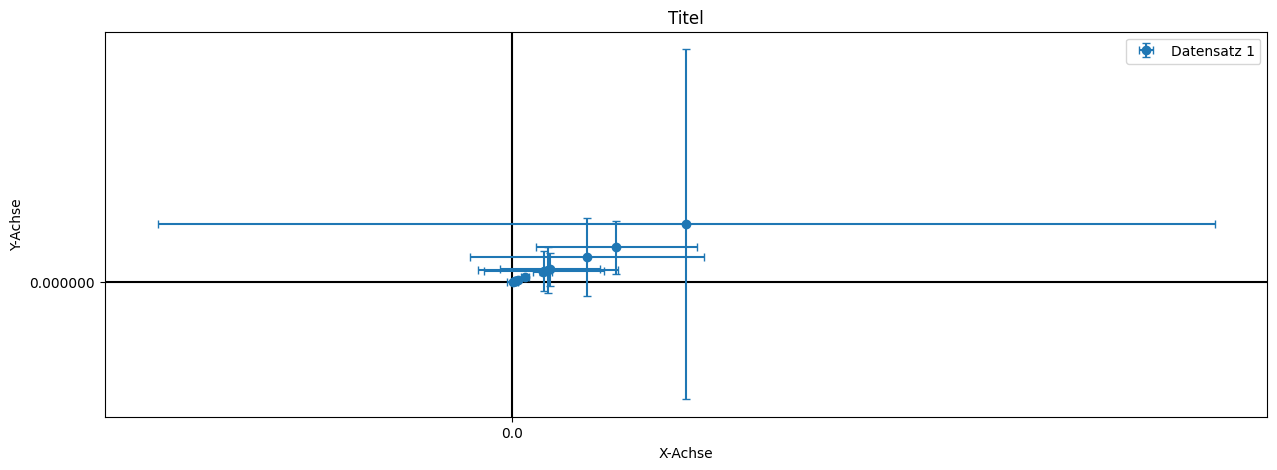

In [ ]:
geraden_fit(exp_nr='', file_n='c_v_g_E_my_r__Ne_gg_Ne.txt', x_major_ticks=10, x_minor_ticks=10, y_major_ticks=0.000001, y_minor_ticks= 0.0000002, y_decimal_places=6)

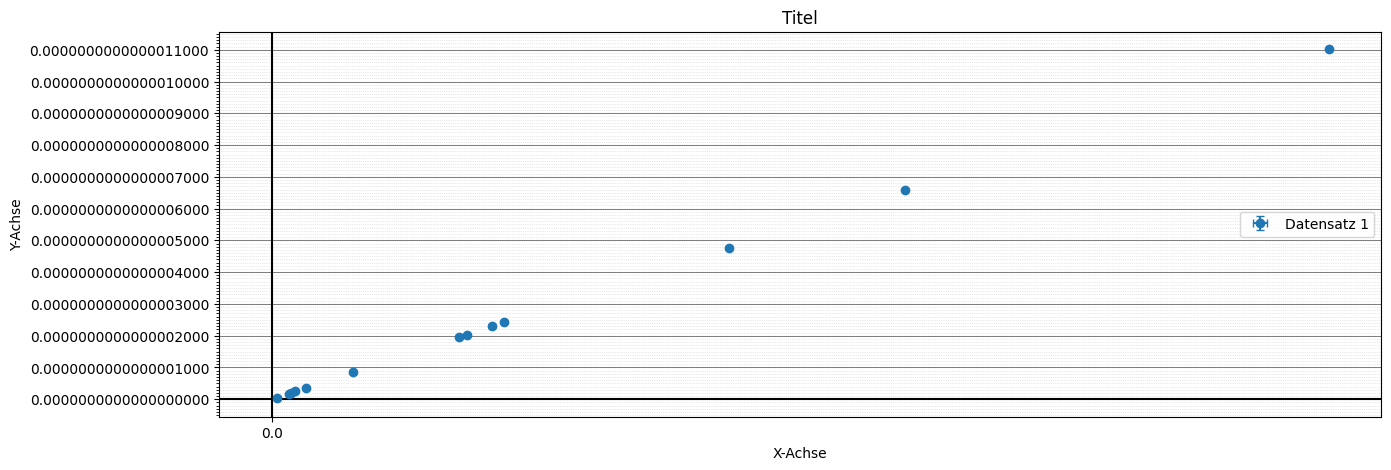

In [105]:
geraden_fit(exp_nr='', file_n='c_v_g_E_my_r__Ne_gg_Ne_noerr.txt', x_major_ticks=10, x_minor_ticks=10, y_major_ticks=0.0000000000000001, y_minor_ticks= 0.00000000000000001, y_decimal_places=19)